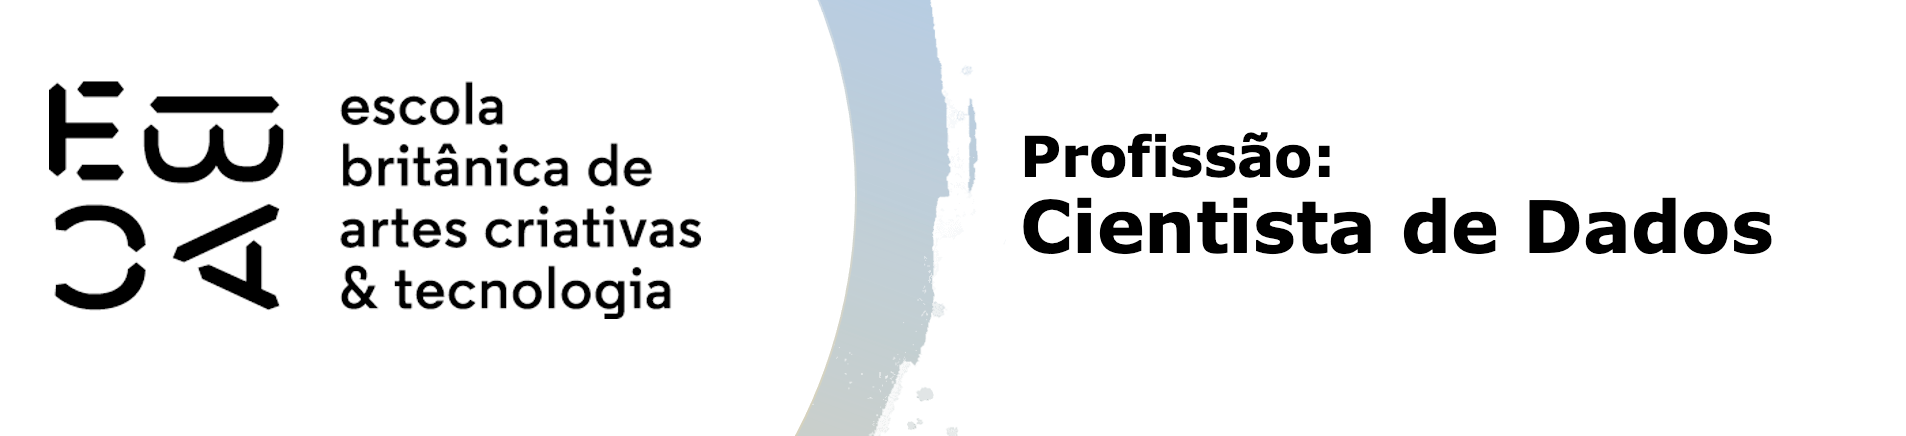

# Projeto Final

Neste projeto, estamos construindo um credit scoring para cartão de crédito, em um desenho amostral com 15 safras, e utilizando 12 meses de performance.

Base de dados ```credit_scoring.ftr```.

In [105]:
from pycaret.classification import *
from pycaret.regression import *

from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import SelectKBest

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import statsmodels.formula.api as smf
import statsmodels.api as sm

from sklearn import metrics
from scipy.stats import ks_2samp
from scipy.stats import t

from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

df = pd.read_feather('credit_scoring.ftr')
df

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749995,2016-03-01,13689,M,N,S,0,Empresário,Superior completo,Casado,Casa,48,3.038356,2.0,2109.99,False
749996,2016-03-01,7000,F,N,S,0,Pensionista,Médio,Solteiro,Casa,65,NaN,1.0,1389.39,False
749997,2016-03-01,14023,M,S,N,2,Assalariado,Médio,Casado,Casa,43,10.375342,4.0,649.06,True
749998,2016-03-01,2396,F,N,S,0,Assalariado,Médio,Viúvo,Casa,56,13.780822,1.0,4216.72,True


## Amostragem

Separe os três últimos meses como safras de validação *out of time* (oot).

Variáveis:<br>
Considere que a variável ```data_ref``` não é uma variável explicativa, é somente uma variável indicadora da safra, e não deve ser utilizada na modelagem. A variávei ```index``` é um identificador do cliente, e também não deve ser utilizada como covariável (variável explicativa). As restantes podem ser utilizadas para prever a inadimplência, incluindo a renda.


In [106]:
valid = (df['data_ref'] >= '2016-01-01')
df_valid = df.loc[valid]
df_valid

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
600000,2016-01-01,8906,F,S,S,2,Assalariado,Superior completo,Casado,Casa,38,7.383562,4.0,2969.49,True
600001,2016-01-01,5063,F,N,S,0,Assalariado,Médio,Casado,Casa,55,8.471233,2.0,6278.37,False
600002,2016-01-01,16401,M,S,S,1,Assalariado,Médio,União,Casa,39,8.884932,3.0,14010.18,False
600003,2016-01-01,6786,F,N,S,1,Assalariado,Médio,União,Com os pais,31,1.794521,3.0,2875.81,False
600004,2016-01-01,13466,M,S,N,0,Assalariado,Médio,Casado,Casa,27,7.019178,2.0,2737.19,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749995,2016-03-01,13689,M,N,S,0,Empresário,Superior completo,Casado,Casa,48,3.038356,2.0,2109.99,False
749996,2016-03-01,7000,F,N,S,0,Pensionista,Médio,Solteiro,Casa,65,NaN,1.0,1389.39,False
749997,2016-03-01,14023,M,S,N,2,Assalariado,Médio,Casado,Casa,43,10.375342,4.0,649.06,True
749998,2016-03-01,2396,F,N,S,0,Assalariado,Médio,Viúvo,Casa,56,13.780822,1.0,4216.72,True


In [107]:
treino = (df['data_ref'] >= '2015-01-01') & (df['data_ref'] <= '2015-12-01')
df1 = df.loc[treino]
df1

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
599995,2015-12-01,2205,F,S,N,0,Assalariado,Médio,União,Casa,47,23.690411,2.0,11009.92,False
599996,2015-12-01,1266,M,S,N,1,Empresário,Superior completo,Casado,Casa,31,3.756164,3.0,4472.60,False
599997,2015-12-01,13085,F,N,N,0,Pensionista,Médio,Casado,Casa,62,NaN,2.0,5117.17,True
599998,2015-12-01,10964,F,N,N,0,Assalariado,Superior completo,Casado,Casa,40,12.939726,2.0,2885.45,True


## Descritiva básica univariada

- Descreva a base quanto ao número de linhas, número de linhas para cada mês em ```data_ref```.
- Faça uma descritiva básica univariada de cada variável. Considere as naturezas diferentes: qualitativas e quantitativas.

In [108]:
df1['data_ref'].groupby(df1['data_ref'].dt.month).agg('count')

data_ref
1     50000
2     50000
3     50000
4     50000
5     50000
6     50000
7     50000
8     50000
9     50000
10    50000
11    50000
12    50000
Name: data_ref, dtype: int64

In [109]:
df_valid.isna().sum()

data_ref                     0
index                        0
sexo                         0
posse_de_veiculo             0
posse_de_imovel              0
qtd_filhos                   0
tipo_renda                   0
educacao                     0
estado_civil                 0
tipo_residencia              0
idade                        0
tempo_emprego            25082
qt_pessoas_residencia        0
renda                        0
mau                          0
dtype: int64

In [110]:
mean_value=df_valid['tempo_emprego'].mean()

df_valid['tempo_emprego'].fillna(value=mean_value, inplace=True)
df_valid

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
600000,2016-01-01,8906,F,S,S,2,Assalariado,Superior completo,Casado,Casa,38,7.383562,4.0,2969.49,True
600001,2016-01-01,5063,F,N,S,0,Assalariado,Médio,Casado,Casa,55,8.471233,2.0,6278.37,False
600002,2016-01-01,16401,M,S,S,1,Assalariado,Médio,União,Casa,39,8.884932,3.0,14010.18,False
600003,2016-01-01,6786,F,N,S,1,Assalariado,Médio,União,Com os pais,31,1.794521,3.0,2875.81,False
600004,2016-01-01,13466,M,S,N,0,Assalariado,Médio,Casado,Casa,27,7.019178,2.0,2737.19,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749995,2016-03-01,13689,M,N,S,0,Empresário,Superior completo,Casado,Casa,48,3.038356,2.0,2109.99,False
749996,2016-03-01,7000,F,N,S,0,Pensionista,Médio,Solteiro,Casa,65,7.750898,1.0,1389.39,False
749997,2016-03-01,14023,M,S,N,2,Assalariado,Médio,Casado,Casa,43,10.375342,4.0,649.06,True
749998,2016-03-01,2396,F,N,S,0,Assalariado,Médio,Viúvo,Casa,56,13.780822,1.0,4216.72,True


In [111]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 600000 entries, 0 to 599999
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   data_ref               600000 non-null  datetime64[ns]
 1   index                  600000 non-null  int64         
 2   sexo                   600000 non-null  object        
 3   posse_de_veiculo       600000 non-null  object        
 4   posse_de_imovel        600000 non-null  object        
 5   qtd_filhos             600000 non-null  int64         
 6   tipo_renda             600000 non-null  object        
 7   educacao               600000 non-null  object        
 8   estado_civil           600000 non-null  object        
 9   tipo_residencia        600000 non-null  object        
 10  idade                  600000 non-null  int64         
 11  tempo_emprego          499125 non-null  float64       
 12  qt_pessoas_residencia  600000 non-null  float64  

In [112]:
mean_value=df1['tempo_emprego'].mean()

df1['tempo_emprego'].fillna(value=mean_value, inplace=True)
df1

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
599995,2015-12-01,2205,F,S,N,0,Assalariado,Médio,União,Casa,47,23.690411,2.0,11009.92,False
599996,2015-12-01,1266,M,S,N,1,Empresário,Superior completo,Casado,Casa,31,3.756164,3.0,4472.60,False
599997,2015-12-01,13085,F,N,N,0,Pensionista,Médio,Casado,Casa,62,7.747992,2.0,5117.17,True
599998,2015-12-01,10964,F,N,N,0,Assalariado,Superior completo,Casado,Casa,40,12.939726,2.0,2885.45,True


In [113]:
metadados = pd.DataFrame(df1.dtypes, columns=['dtype'])
metadados['nmissing'] = df1.isna().sum()
metadados['valores_unicos'] = df1.nunique()

metadados

,dtype,nmissing,valores_unicos
data_ref,datetime64[ns],0,12
index,int64,0,16650
sexo,object,0,2
posse_de_veiculo,object,0,2
posse_de_imovel,object,0,2
qtd_filhos,int64,0,8
tipo_renda,object,0,5
educacao,object,0,5
estado_civil,object,0,5
tipo_residencia,object,0,6


In [114]:
def IV(variavel, resposta):
    tab = pd.crosstab(variavel, resposta, margins=True, margins_name='total')

    rótulo_evento = tab.columns[0]
    rótulo_nao_evento = tab.columns[1]

    tab['pct_evento'] = tab[rótulo_evento]/tab.loc['total',rótulo_evento]
    tab['ep'] = tab[rótulo_evento]/tab.loc['total',rótulo_evento]
    
    tab['pct_nao_evento'] = tab[rótulo_nao_evento]/tab.loc['total',rótulo_nao_evento]
    tab['woe'] = np.log(tab.pct_evento/tab.pct_nao_evento)
    tab['iv_parcial'] = (tab.pct_evento - tab.pct_nao_evento)*tab.woe
    return tab['iv_parcial'].sum()

In [115]:
metadados = pd.DataFrame(df1.dtypes, columns=['dtype'])
metadados['nmissing'] = df1.isna().sum()
metadados['valores_unicos'] = df1.nunique()
metadados['papel'] = 'covariavel'
metadados.loc['mau','papel'] = 'resposta'
metadados.loc['bom','papel'] = 'resposta'
metadados

,dtype,nmissing,valores_unicos,papel
data_ref,datetime64[ns],0.0,12.0,covariavel
index,int64,0.0,16650.0,covariavel
sexo,object,0.0,2.0,covariavel
posse_de_veiculo,object,0.0,2.0,covariavel
posse_de_imovel,object,0.0,2.0,covariavel
qtd_filhos,int64,0.0,8.0,covariavel
tipo_renda,object,0.0,5.0,covariavel
educacao,object,0.0,5.0,covariavel
estado_civil,object,0.0,5.0,covariavel
tipo_residencia,object,0.0,6.0,covariavel


In [116]:
for var in metadados[metadados.papel=='covariavel'].index:
    if  (metadados.loc[var, 'valores_unicos']>6):
        metadados.loc[var, 'IV'] = IV(pd.qcut(df1[var],5,duplicates='drop'), df1.mau)
    else: 
        metadados.loc[var, 'IV'] = IV(df1[var], df1.mau)

    
metadados

,dtype,nmissing,valores_unicos,papel,IV
data_ref,datetime64[ns],0.0,12.0,covariavel,0.247065
index,int64,0.0,16650.0,covariavel,0.002716
sexo,object,0.0,2.0,covariavel,0.002665
posse_de_veiculo,object,0.0,2.0,covariavel,0.000075
posse_de_imovel,object,0.0,2.0,covariavel,0.009690
qtd_filhos,int64,0.0,8.0,covariavel,0.000055
tipo_renda,object,0.0,5.0,covariavel,0.009718
educacao,object,0.0,5.0,covariavel,0.003690
estado_civil,object,0.0,5.0,covariavel,0.001305
tipo_residencia,object,0.0,6.0,covariavel,0.003330


## Descritiva bivariada

Faça uma análise descritiva bivariada de cada variável

In [117]:
def biv_discreta(var, df1):
    df1['bom'] = 1-df1.mau
    g = df1.groupby(var)

    biv = pd.DataFrame({'qt_bom': g['bom'].sum(),
                        'qt_mau': g['mau'].sum(),
                        'mau':g['mau'].mean(), 
                        var: g['mau'].mean().index, 
                        'cont':g[var].count()})
    
    biv['ep'] = (biv.mau*(1-biv.mau)/biv.cont)**.5
    biv['mau_sup'] = biv.mau+t.ppf([0.975], biv.cont-1)*biv.ep
    biv['mau_inf'] = biv.mau+t.ppf([0.025], biv.cont-1)*biv.ep
    
    biv['logit'] = np.log(biv.mau/(1-biv.mau))
    biv['logit_sup'] = np.log(biv.mau_sup/(1-biv.mau_sup))
    biv['logit_inf'] = np.log(biv.mau_inf/(1-biv.mau_inf))

    tx_mau_geral = df1.mau.mean()
    woe_geral = np.log(df1.mau.mean() / (1 - df1.mau.mean()))

    biv['woe'] = biv.logit - woe_geral
    biv['woe_sup'] = biv.logit_sup - woe_geral
    biv['woe_inf'] = biv.logit_inf - woe_geral

    fig, ax = plt.subplots(2,1, figsize=(8,6))
    ax[0].plot(biv[var], biv.woe, ':bo', label='woe')
    ax[0].plot(biv[var], biv.woe_sup, 'o:r', label='limite superior')
    ax[0].plot(biv[var], biv.woe_inf, 'o:r', label='limite inferior')
    
    num_cat = biv.shape[0]
    ax[0].set_xlim([-.3, num_cat-.7])

    ax[0].set_ylabel("Weight of Evidence")
    ax[0].legend(bbox_to_anchor=(.83, 1.17), ncol=3)
    
    ax[0].set_xticks(list(range(num_cat)))
    ax[0].set_xticklabels(biv[var], rotation=15)
    
    ax[1] = biv.cont.plot.bar()
    return biv

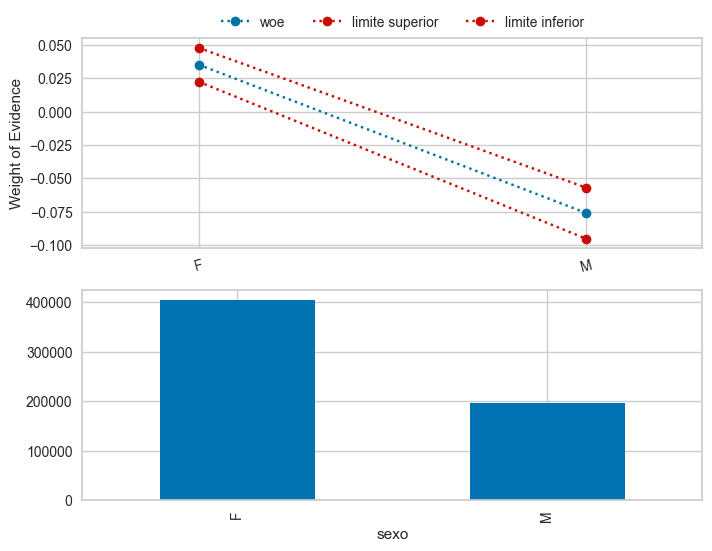

In [118]:
biv_discreta('sexo', df1);

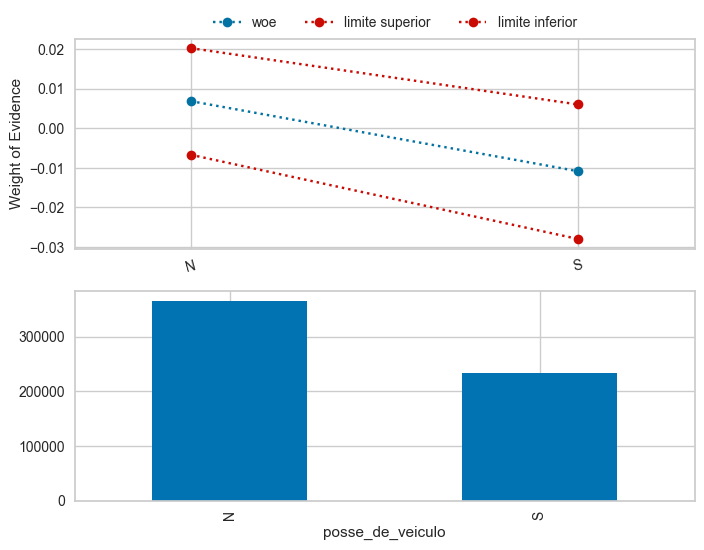

In [119]:
biv_discreta('posse_de_veiculo', df1);

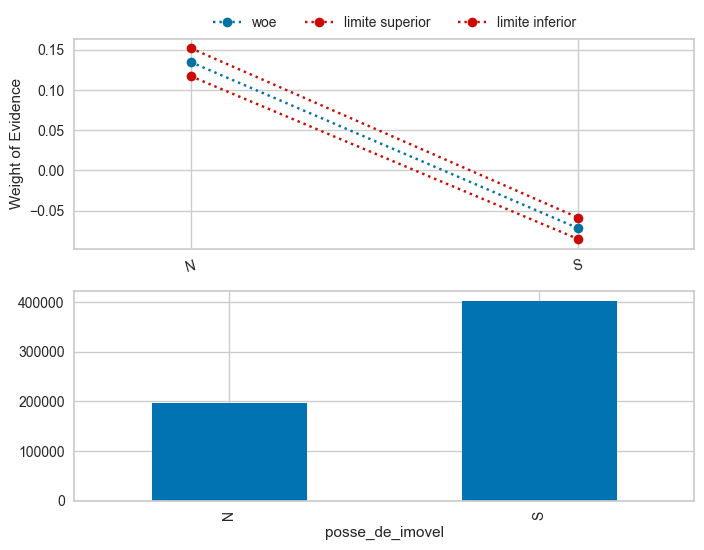

In [120]:
biv_discreta('posse_de_imovel', df1);

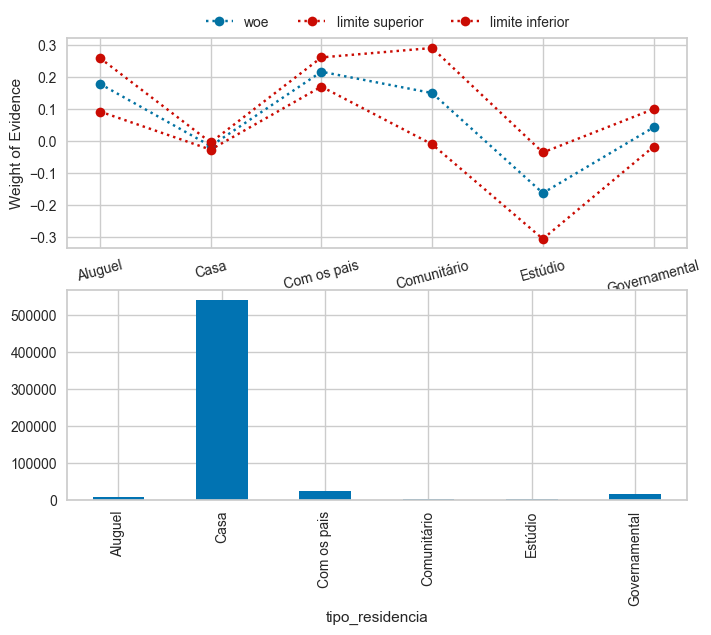

In [121]:
biv_discreta('tipo_residencia', df1);

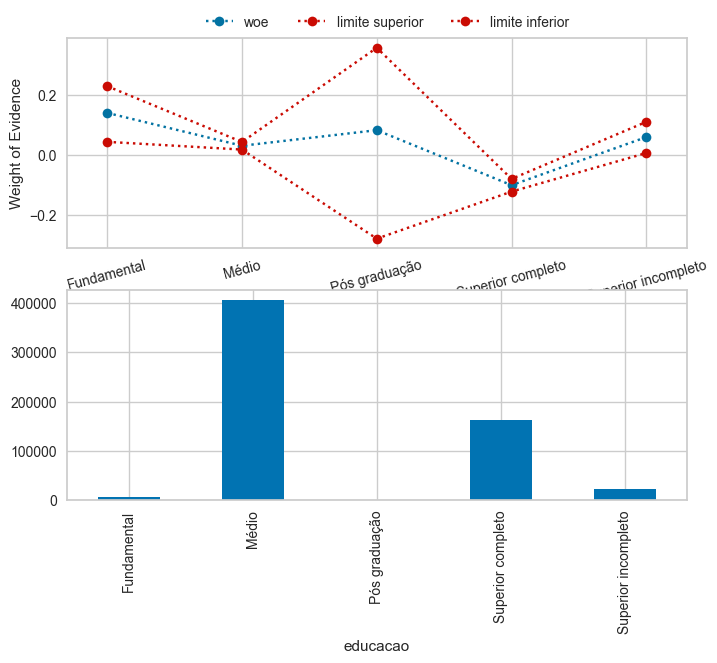

In [122]:
biv_discreta('educacao', df1);

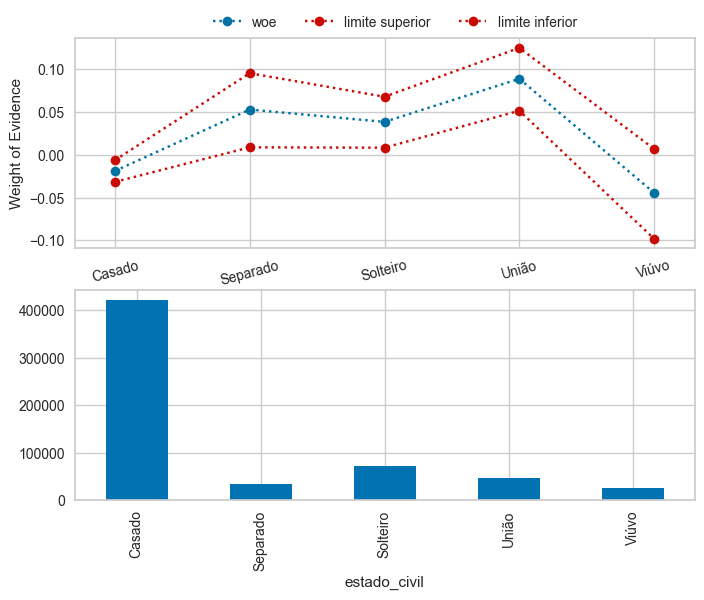

In [123]:
biv_discreta('estado_civil', df1);

,qt_bom,qt_mau,mau,tipo_renda,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
tipo_renda,,,,,,,,,,,,,,
Assalariado,288865,19595,0.063525,Assalariado,308460,0.000439,0.064386,0.062665,-2.690685,-2.676307,-2.705246,0.042006,0.056384,0.027445
Bolsista,279,12,0.041237,Bolsista,291,0.011656,0.064178,0.018296,-3.146305,-2.679758,-3.982616,-0.413614,0.052933,-1.249925
Empresário,129935,8206,0.059403,Empresário,138141,0.000636,0.060650,0.058157,-2.762169,-2.740076,-2.784700,-0.029478,-0.007385,-0.052009
Pensionista,94627,6500,0.064276,Pensionista,101127,0.000771,0.065787,0.062764,-2.678141,-2.653280,-2.703552,0.054550,0.079411,0.029139
Servidor público,49651,2330,0.044824,Servidor público,51981,0.000908,0.046603,0.043045,-3.059150,-3.018369,-3.101504,-0.326459,-0.285678,-0.368813


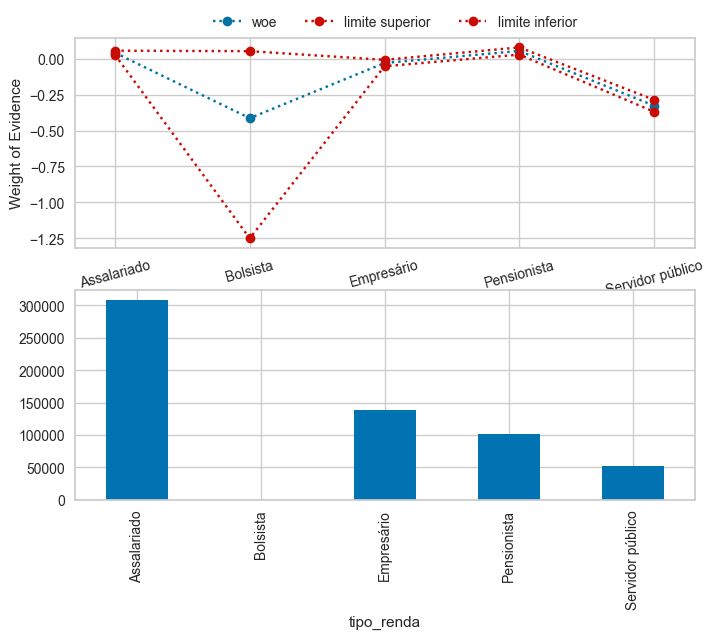

In [124]:
biv_discreta('tipo_renda', df1)

In [125]:
def biv_continua(var, ncat, df1):
    df1['bom'] = 1-df1.mau
    cat_srs, bins = pd.qcut(df1[var], ncat, retbins=True, precision=0, duplicates='drop')
    g = df1.groupby(cat_srs)

    biv = pd.DataFrame({'qt_bom': g['bom'].sum(),
                        'qt_mau': g['mau'].sum(),
                        'mau':g['mau'].mean(), 
                        var: g[var].mean(), 
                        'cont':g[var].count()})
    
    biv['ep'] = (biv.mau*(1-biv.mau)/biv.cont)**.5
    biv['mau_sup'] = biv.mau+t.ppf([0.975], biv.cont-1)*biv.ep
    biv['mau_inf'] = biv.mau+t.ppf([0.025], biv.cont-1)*biv.ep
    
    biv['logit'] = np.log(biv.mau/(1-biv.mau))
    biv['logit_sup'] = np.log(biv.mau_sup/(1-biv.mau_sup))
    biv['logit_inf'] = np.log(biv.mau_inf/(1-biv.mau_inf))

    tx_mau_geral = df1.mau.mean()
    woe_geral = np.log(df1.mau.mean() / (1 - df1.mau.mean()))

    biv['woe'] = biv.logit - woe_geral
    biv['woe_sup'] = biv.logit_sup - woe_geral
    biv['woe_inf'] = biv.logit_inf - woe_geral

    fig, ax = plt.subplots(2,1, figsize=(8,6))
    ax[0].plot(biv[var], biv.woe, ':bo', label='woe')
    ax[0].plot(biv[var], biv.woe_sup, 'o:r', label='limite superior')
    ax[0].plot(biv[var], biv.woe_inf, 'o:r', label='limite inferior')
    
    num_cat = biv.shape[0]

    ax[0].set_ylabel("Weight of Evidence")
    ax[0].legend(bbox_to_anchor=(.83, 1.17), ncol=3)
    
    ax[1] = biv.cont.plot.bar()
    return None

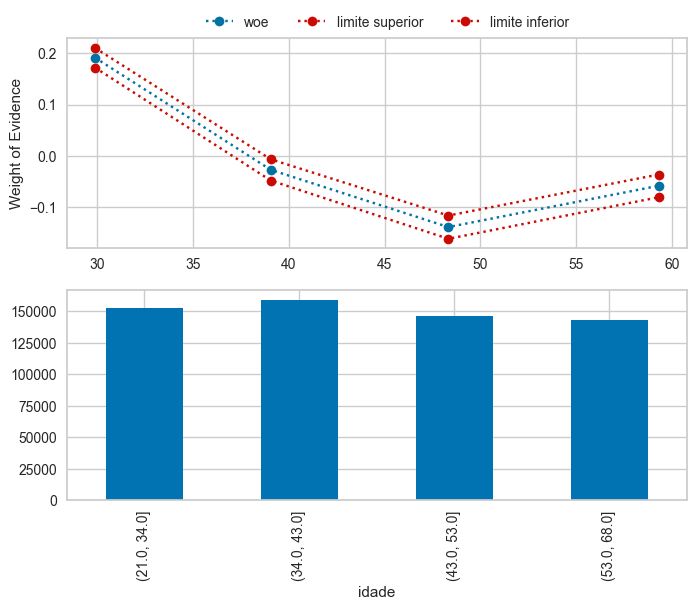

In [126]:
biv_continua('idade', 4, df1)

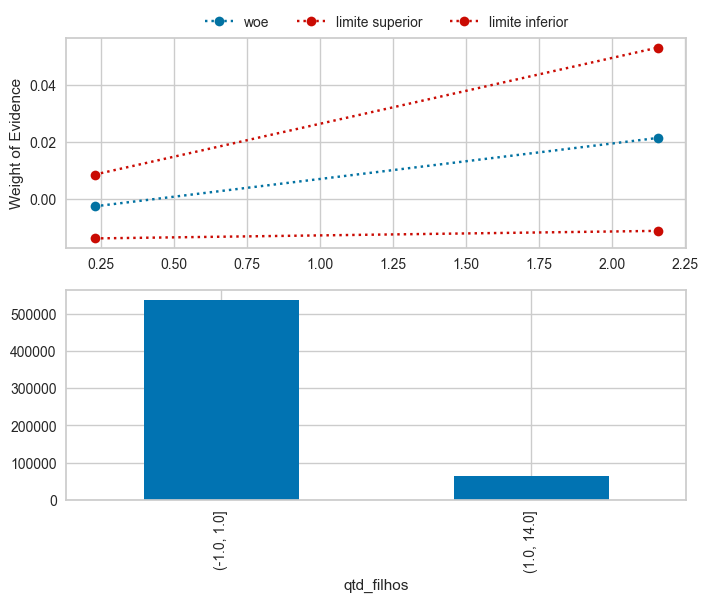

In [127]:
biv_continua('qtd_filhos', 5, df1)

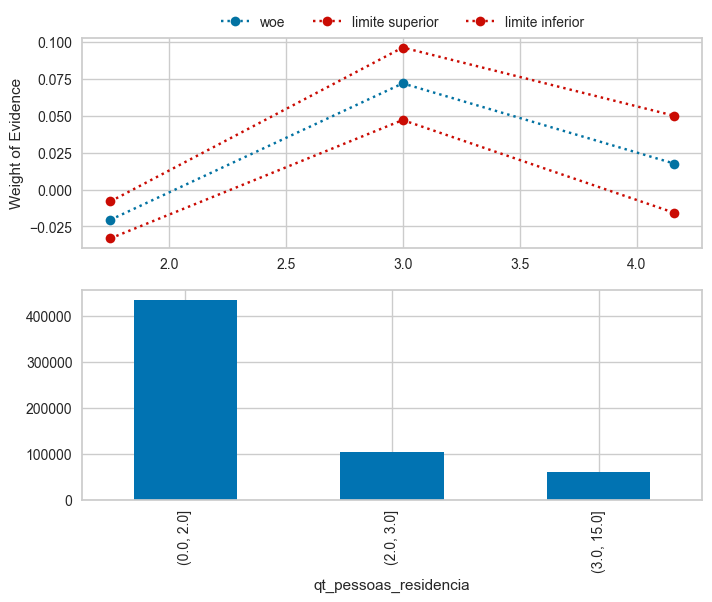

In [128]:
biv_continua('qt_pessoas_residencia', 4, df1)

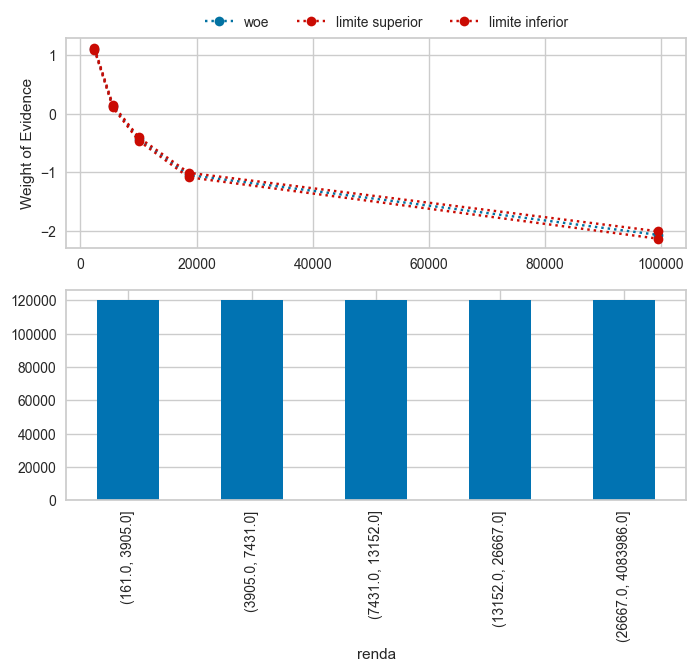

In [129]:
biv_continua('renda', 5, df1)

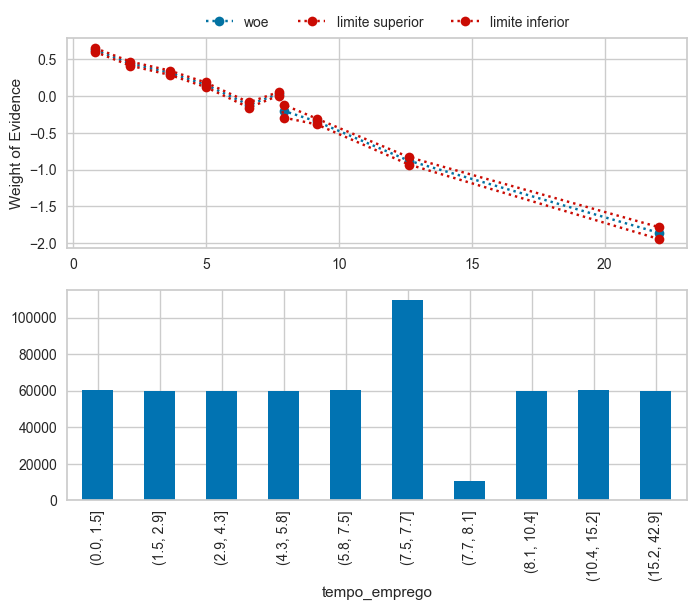

In [130]:
biv_continua('tempo_emprego', 10, df1)

## Desenvolvimento do modelo

Desenvolva um modelo de *credit scoring* através de uma regressão logística.

- Trate valores missings e outliers
- Trate 'zeros estruturais'
- Faça agrupamentos de categorias conforme vimos em aula
- Proponha uma equação preditiva para 'mau'
- Caso hajam categorias não significantes, justifique

In [131]:
formula_teste = '''
    mau ~ sexo + posse_de_veiculo + posse_de_imovel + qtd_filhos + tipo_renda + 
    educacao + estado_civil + tipo_residencia + idade + tempo_emprego + 
    qt_pessoas_residencia + renda
'''

rl = smf.glm(formula_teste, data=df1, family=sm.families.Binomial()).fit()

rl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                      Generalized Linear Model Regression Results                      
=======================================================================================
Dep. Variable:     ['mau[False]', 'mau[True]']   No. Observations:               600000
Model:                                     GLM   Df Residuals:                   599974
Model Family:                         Binomial   Df Model:                           25
Link Function:                           Logit   Scale:                          1.0000
Method:                                   IRLS   Log-Likelihood:            -1.2483e+05
Date:                         Wed, 27 Mar 2024   Deviance:                   2.4966e+05
Time:                                 15:51:16   Pearson chi2:                 1.61e+16
No. Iterations:                             11   Pseudo R-squ. (CS):            0.04277
Covariance Type:                     nonrobust                                         
====================================================================================================
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                            1.1298      0.192      5.869      0.000       0.752       1.507
sexo[T.M]                            0.1263      0.013      9.621      0.000       0.101       0.152
posse_de_veiculo[T.S]               -0.0319      0.012     -2.578      0.010      -0.056      -0.008
posse_de_imovel[T.S]                 0.0857      0.012      7.251      0.000       0.063       0.109
tipo_renda[T.Bolsista]              -0.1252      0.300     -0.417      0.677      -0.713       0.463
tipo_renda[T.Empresário]             0.0531      0.014      3.788      0.000       0.026       0.081
tipo_renda[T.Pensionista]            0.0397      0.020      1.958      0.050   -4.38e-05       0.079
tipo_renda[T.Servidor público]       0.0317      0.023      1.366      0.172      -0.014       0.077
educacao[T.Médio]                    0.0305      0.049      0.625      0.532      -0.065       0.126
educacao[T.Pós graduação]            0.0460      0.168      0.274      0.784      -0.283       0.375
educacao[T.Superior completo]        0.0906      0.050      1.821      0.069      -0.007       0.188
educacao[T.Superior incompleto]      0.0803      0.056      1.441      0.149      -0.029       0.190
estado_civil[T.Separado]             0.0856      0.092      0.927      0.354      -0.096       0.267
estado_civil[T.Solteiro]             0.1161      0.090      1.283      0.199      -0.061       0.293
estado_civil[T.União]               -0.0475      0.020     -2.332      0.020      -0.087      -0.008
estado_civil[T.Viúvo]                0.1573      0.094      1.673      0.094      -0.027       0.342
tipo_residencia[T.Casa]              0.0891      0.044      2.023      0.043       0.003       0.175
tipo_residencia[T.Com os pais]       0.0743      0.050      1.498      0.134      -0.023       0.171
tipo_residencia[T.Comunitário]       0.1402      0.089      1.568      0.117      -0.035       0.315
tipo_residencia[T.Estúdio]           0.0335      0.082      0.407      0.684      -0.128       0.195
tipo_residencia[T.Governamental]     0.0862      0.053      1.616      0.106      -0.018       0.191
qtd_filhos                          -0.1269      0.090     -1.417      0.156      -0.302       0.049
idade                            -9.477e-05      0.001     -0.135      0.893      -0.001       0.001
tempo_emprego                        0.0237      0.002     13.133      0.000       0.020       0.027
qt_pessoas_residencia                0.1237      0.089      1.384      0.166      -0.051       0.299
renda                                0.0001   1.09e-06     93.637      0.000    9.95e-05       0.000
=======================================================

In [132]:
formula = '''
    mau ~ posse_de_imovel + tempo_emprego + renda
'''

rl = smf.glm(formula, data=df1, family=sm.families.Binomial()).fit()

rl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                      Generalized Linear Model Regression Results                      
=======================================================================================
Dep. Variable:     ['mau[False]', 'mau[True]']   No. Observations:               600000
Model:                                     GLM   Df Residuals:                   599996
Model Family:                         Binomial   Df Model:                            3
Link Function:                           Logit   Scale:                          1.0000
Method:                                   IRLS   Log-Likelihood:            -1.2490e+05
Date:                         Wed, 27 Mar 2024   Deviance:                   2.4980e+05
Time:                                 15:51:19   Pearson chi2:                 1.63e+16
No. Iterations:                             11   Pseudo R-squ. (CS):            0.04255
Covariance Type:                     nonrobust                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                1.5488      0.013    121.931      0.000       1.524       1.574
posse_de_imovel[T.S]     0.0821      0.011      7.200      0.000       0.060       0.104
tempo_emprego            0.0226      0.002     13.603      0.000       0.019       0.026
renda                    0.0001   1.08e-06     95.620      0.000       0.000       0.000
========================================================================================
"""

Retirei categorias pelo IV e P>|z|

## Avaliação do modelo

Avalie o poder discriminante do modelo pelo menos avaliando acurácia, KS e Gini.

Avalie estas métricas nas bases de desenvolvimento e *out of time*.

In [133]:
df1['predito1'] = rl.predict(df1)
df1.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau,bom,predito1
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False,1,0.876860
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False,1,0.887009
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False,1,0.847768
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False,1,0.962667
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False,1,0.884619


In [134]:
acc = metrics.accuracy_score(df1['mau'], df1['predito1']<.5)
print('Acurácia: {0:.2f}%'.format(acc*100))

#AUC
fpr, tpr, thresholds = metrics.roc_curve(df1['mau'], df1['predito1'])
auc_ = metrics.auc(fpr, tpr)
#Gini
gini = 2*auc_ -1
#KS
ks = ks_2samp(df1.loc[df1['mau'] == 1, 'predito1'], df1.loc[df1['mau'] != 1, 'predito1']).statistic

print('KS: {0:.2f}% \nAUC: {1:.2f}% \nGINI: {2:.2f}%'
      .format(ks*100, auc_*100, gini*100))

Acurácia: 93.89%
KS: 39.55% 
AUC: 23.30% 
GINI: -53.40%


In [135]:
rl2 = smf.glm(formula, data=df_valid, family=sm.families.Binomial()).fit()

rl2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                      Generalized Linear Model Regression Results                      
=======================================================================================
Dep. Variable:     ['mau[False]', 'mau[True]']   No. Observations:               150000
Model:                                     GLM   Df Residuals:                   149996
Model Family:                         Binomial   Df Model:                            3
Link Function:                           Logit   Scale:                          1.0000
Method:                                   IRLS   Log-Likelihood:                -57215.
Date:                         Wed, 27 Mar 2024   Deviance:                   1.1443e+05
Time:                                 15:51:20   Pearson chi2:                 1.45e+16
No. Iterations:                              9   Pseudo R-squ. (CS):            0.06844
Covariance Type:                     nonrobust                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.6957      0.018     39.658      0.000       0.661       0.730
posse_de_imovel[T.S]     0.1043      0.016      6.648      0.000       0.074       0.135
tempo_emprego            0.0267      0.002     11.332      0.000       0.022       0.031
renda                    0.0002   4.33e-06     57.282      0.000       0.000       0.000
========================================================================================
"""

In [136]:
df_valid['predito'] = rl2.predict(df_valid)
df_valid.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau,predito
600000,2016-01-01,8906,F,S,S,2,Assalariado,Superior completo,Casado,Casa,38,7.383562,4.0,2969.49,True,0.849812
600001,2016-01-01,5063,F,N,S,0,Assalariado,Médio,Casado,Casa,55,8.471233,2.0,6278.37,False,0.929695
600002,2016-01-01,16401,M,S,S,1,Assalariado,Médio,União,Casa,39,8.884932,3.0,14010.18,False,0.989107
600003,2016-01-01,6786,F,N,S,1,Assalariado,Médio,União,Com os pais,31,1.794521,3.0,2875.81,False,0.826420
600004,2016-01-01,13466,M,S,N,0,Assalariado,Médio,Casado,Casa,27,7.019178,2.0,2737.19,False,0.826572


In [137]:
acc = metrics.accuracy_score(df_valid['mau'], df_valid['predito']<.5)
print('Acurácia: {0:.2f}%'.format(acc*100))

#AUC
fpr, tpr, thresholds = metrics.roc_curve(df_valid['mau'], df_valid['predito'])
auc_ = metrics.auc(fpr, tpr)
#Gini
gini = 2*auc_ -1
#KS
ks = ks_2samp(df_valid.loc[df_valid['mau'] == 1, 'predito'], df_valid.loc[df_valid['mau'] != 1, 'predito']).statistic

print('KS: {0:.2f}% \nAUC: {1:.2f}% \nGINI: {2:.2f}%'
      .format(ks*100, auc_*100, gini*100))

Acurácia: 85.33%
KS: 34.28% 
AUC: 26.54% 
GINI: -46.92%


# a - Criar um pipeline utilizando o sklearn pipeline para o preprocessamento

## Pré processamento

### Substituição de nulos (nans)

Existe nulos na base? é dado numérico ou categórico? qual o valor de substituição? média? valor mais frequente? etc

In [138]:
imp_pipe = SimpleImputer(strategy='mean')

### Remoção de outliers

Como identificar outlier? Substituir o outlier por algum valor? Remover a linha?

In [139]:
out_pipe = IsolationForest(random_state = 13)

### Seleção de variáveis

Qual tipo de técnica? Boruta? Feature importance? 

In [140]:
fs_pipe = SelectKBest(k=5)

### Redução de dimensionalidade (PCA)

Aplicar PCA para reduzir a dimensionalidade para 5

In [141]:
pca_pipe = PCA(n_components=5)

### Criação de dummies

Aplicar o get_dummies() ou onehotencoder() para transformar colunas catégoricas do dataframe em colunas de 0 e 1. 
- sexo
- posse_de_veiculo
- posse_de_imovel
- tipo_renda
- educacao
- estado_civil
- tipo_residencia

In [142]:
dummies_pipe = OneHotEncoder(max_categories=10)

### Pipeline 

Crie um pipeline contendo essas funções.

preprocessamento()
- substituicao de nulos
- remoção outliers
- PCA
- Criação de dummy de pelo menos 1 variável (posse_de_veiculo)

In [143]:
pipe = Pipeline(steps=[("imputer", imp_pipe),
                       ("outlier", out_pipe),
                       ("feature_selection", fs_pipe), 
                       ("pca", pca_pipe), 
                       ("onehotencoding", dummies_pipe)])

# b - Pycaret na base de dados 

Utilize o pycaret para pre processar os dados e rodar o modelo **lightgbm**. Faça todos os passos a passos da aula e gere os gráficos finais. E o pipeline de toda a transformação.

In [144]:
df = pd.read_feather('credit_scoring.ftr')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


In [145]:
df.dtypes

data_ref                 datetime64[ns]
index                             int64
sexo                             object
posse_de_veiculo                 object
posse_de_imovel                  object
qtd_filhos                        int64
tipo_renda                       object
educacao                         object
estado_civil                     object
tipo_residencia                  object
idade                             int64
tempo_emprego                   float64
qt_pessoas_residencia           float64
renda                           float64
mau                                bool
dtype: object

In [146]:
df.qtd_filhos = df.qtd_filhos.astype(float)

In [147]:
m38 = setup(data = df, target = 'mau', experiment_name='credit_score')

,Description,Value
0,Session id,6267
1,Target,mau
2,Target type,Regression
3,Original data shape,"(750000, 15)"
4,Transformed data shape,"(750000, 34)"
5,Transformed train set shape,"(525000, 34)"
6,Transformed test set shape,"(225000, 34)"
7,Numeric features,6
8,Date features,1
9,Categorical features,7


In [148]:
lightgbm = create_model('lightgbm')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.1293,0.0645,0.2540,0.0943,0.1778,0.8317
1,0.1304,0.0650,0.2550,0.0961,0.1785,0.8301
2,0.1282,0.0634,0.2517,0.1013,0.1762,0.8290
3,0.1304,0.0652,0.2553,0.1043,0.1785,0.8264
4,0.1308,0.0655,0.2559,0.0968,0.1790,0.8303
5,0.1300,0.0647,0.2544,0.0928,0.1783,0.8309
6,0.1302,0.0657,0.2564,0.0909,0.1793,0.8346
7,0.1317,0.0668,0.2584,0.0975,0.1804,0.8334
8,0.1302,0.0656,0.2561,0.0925,0.1792,0.8340


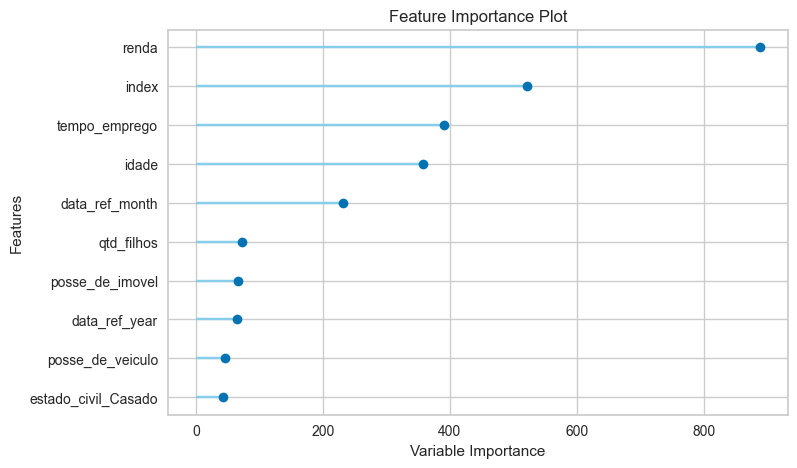

In [149]:
plot_model(lightgbm, plot='feature')

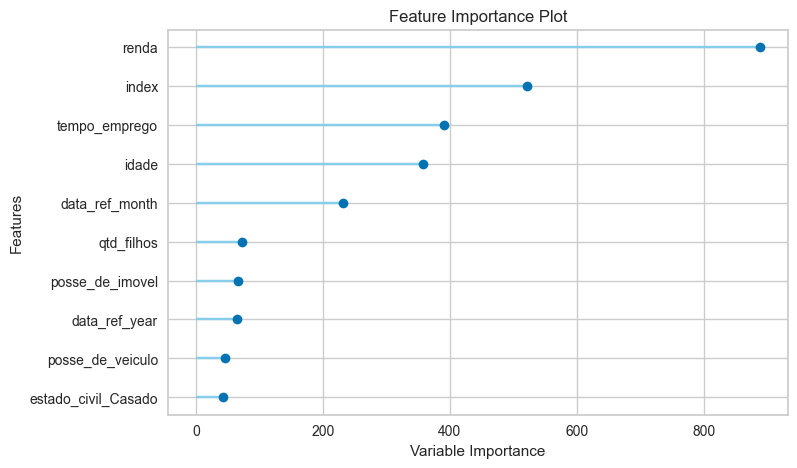

In [151]:
plot_model(lightgbm, plot='feature')

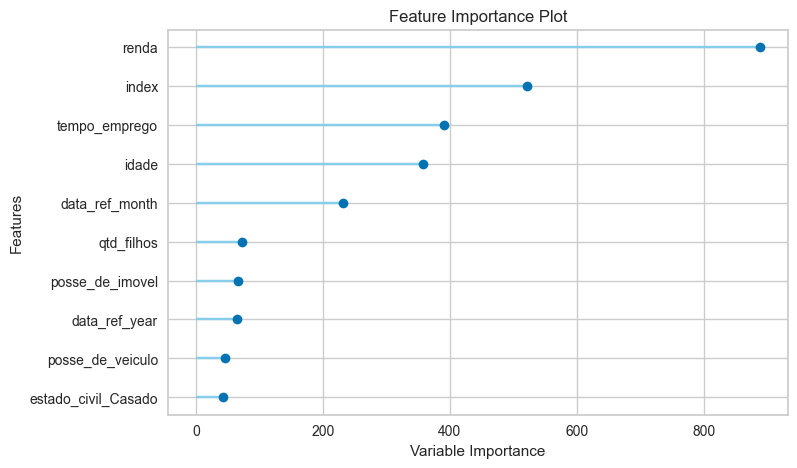

In [155]:
plot_model(lightgbm, plot = 'feature')

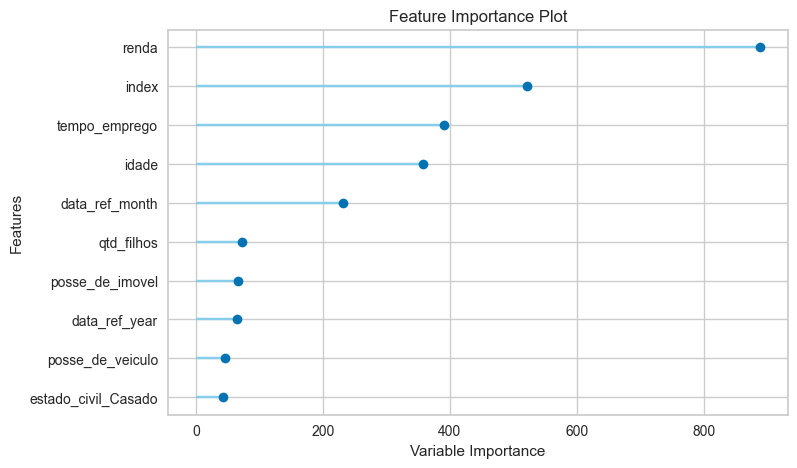

In [157]:
plot_model(lightgbm, plot = 'feature')

In [158]:
predict_model(lightgbm)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.1299,0.0649,0.2548,0.0973,0.1782,0.8311


,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau,prediction_label
677055,2016-02-01,11099,F,N,N,0.0,Assalariado,Superior completo,Viúvo,Casa,42,0.515068,1.0,1295.979980,False,0.242410
370889,2015-08-01,7213,M,N,S,1.0,Empresário,Médio,Casado,Casa,41,11.049315,3.0,155104.859375,False,0.004975
611050,2016-01-01,4100,F,N,N,0.0,Pensionista,Médio,Separado,Casa,64,NaN,1.0,3123.629883,True,0.118934
455314,2015-10-01,956,M,N,S,1.0,Assalariado,Médio,Casado,Casa,26,3.671233,3.0,3387.659912,False,0.099853
329002,2015-07-01,3671,F,N,N,1.0,Assalariado,Médio,União,Aluguel,36,1.794520,3.0,5138.240234,False,0.077751
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51748,2015-02-01,16107,F,S,S,1.0,Assalariado,Médio,União,Casa,42,0.794521,3.0,11340.099609,False,0.037222
589158,2015-12-01,10415,F,N,S,0.0,Pensionista,Superior completo,Casado,Casa,60,NaN,2.0,4059.489990,False,0.085047
228011,2015-05-01,14373,F,N,S,0.0,Servidor público,Superior completo,Casado,Casa,51,20.128767,2.0,112967.156250,False,0.004928
687976,2016-02-01,2719,F,N,S,0.0,Assalariado,Médio,Casado,Casa,36,4.391781,2.0,2552.510010,False,0.130392


In [159]:
save_model(lightgbm,'model_final.pkl')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('date_feature_extractor',
                  TransformerWrapper(exclude=None, include=['data_ref'],
                                     transformer=ExtractDateTimeFeatures(features=['day',
                                                                                   'month',
                                                                                   'year']))),
                 ('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['index', 'qtd_filhos', 'idade',
                                              'tempo_emprego',
                                              'qt_pessoas_residencia', 'renda'],
                                     transformer=Sim...
                  LGBMRegressor(boosting_type='gbdt', class_weight=None,
                                colsample_bytree=1.0, importance_type='split',
                                learning_rate=